# Guia do Projeto - Tech Challenge Fase 4 - Parte 02

## Fase 2: Face Detection — Detecção de Rostos

Agora que já sabemos ler frames do vídeo, vamos detectar rostos em cada frame.

### Conceitos Fundamentais

#### 1. O que é detecção facial?
* Identificar onde estão os rostos em uma imagem
* Retornar uma "caixa delimitadora" (bounding box) para cada rosto
* Indicar o nível de confiança da detecção

#### 2. Por que YOLO Pose?
* **Precisão**: Detecta keypoints faciais reais (nariz, olhos, orelhas)
* **Múltiplas pessoas**: Detecta vários rostos simultaneamente
* **Robustez**: Funciona com diferentes poses e ângulos
* **Confiabilidade**: Não precisa estimar proporções do corpo
* **Python 3.13**: Compatível com versões mais recentes do Python

#### 3. Como funciona?
* **YOLO Pose** detecta keypoints do corpo, incluindo pontos faciais:
  - Nariz (keypoint 0)
  - Olho esquerdo (keypoint 1)
  - Olho direito (keypoint 2)
  - Orelha esquerda (keypoint 3)
  - Orelha direita (keypoint 4)
* Calculamos o bounding box baseado nas coordenadas reais desses keypoints
* Adicionamos padding proporcional para capturar o rosto completo
* Retornamos uma lista de `FaceDetection` com bounding boxes precisos


### Passo 1: Importar dependências e definir modelos

Aqui vamos colocar os códigos do que precisamos utilizar da fase passada (vide em video_processor.ipynb).


In [1]:
import cv2
import os
from typing import Generator, Tuple
import logging
from dataclasses import dataclass


logger = logging.getLogger(__name__)


@dataclass
class BoundingBox:
    x: int
    y: int
    width: int
    height: int


@dataclass
class FaceDetection:
    bounding_box: BoundingBox
    confidence: float


class VideoProcessor:
    def __init__(self, video_path: str):
        # Passo 1: Estrutura básica da classe
        # Validar se o arquivo existe
        if not os.path.exists(video_path):
            raise FileNotFoundError(f"Video file not found: {video_path}")
        
        self.video_path = video_path
        # Abrir o vídeo
        self.cap = cv2.VideoCapture(video_path)
        
        # Verificar se abriu com sucesso
        if not self.cap.isOpened():
            raise ValueError(f"Could not open video: {video_path}")
        
        # Passo 2: Obter informações do vídeo
        self.fps = self.cap.get(cv2.CAP_PROP_FPS)
        self.frame_count = int(self.cap.get(cv2.CAP_PROP_FRAME_COUNT))
        self.width = int(self.cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        self.height = int(self.cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        
        logger.info(
            f"Video loaded: {self.width}x{self.height} @ "
            f"{self.fps}fps, {self.frame_count} frames"
        )
    
    # Passo 3: Método para ler frames (generator)
    def get_frames(self) -> Generator[Tuple[int, float, cv2.Mat], None, None]:
        """
        Gera frames do vídeo um por um.
        
        Yields:
            Tuple[int, float, cv2.Mat]: (frame_number, timestamp, frame)
                - frame_number: número do frame (0, 1, 2, ...)
                - timestamp: tempo em segundos desde o início
                - frame: imagem do frame (numpy array)
        """
        frame_num = 0
        while True:
            ret, frame = self.cap.read()
            if not ret:
                break  # Fim do vídeo
            
            timestamp = frame_num / self.fps
            yield frame_num, timestamp, frame
            frame_num += 1
            
    # Passo 4: Métodos auxiliares
    def release(self):
        """Libera os recursos do vídeo."""
        self.cap.release()
    
    def get_video_info(self) -> dict:
        """Retorna informações do vídeo."""
        return {
            "fps": self.fps,
            "frame_count": self.frame_count,
            "width": self.width,
            "height": self.height,
            "duration": self.frame_count / self.fps if self.fps > 0 else 0
        }

### Passo 2: Criar a classe FaceDetector
Vamos criar a classe que vai detectar rostos usando YOLOv11

In [2]:
from ultralytics import YOLO
import numpy as np

class FaceDetector:
    """
    Detecta rostos em frames de vídeo usando YOLO11.
    
    YOLO11 oferece melhor performance que MediaPipe para:
    - Múltiplas pessoas simultaneamente
    - Oclusão parcial
    - Poses complexas
    - Compatibilidade com Python 3.13
    """
    
    def __init__(self, model_path: str = "yolo11n-pose.pt", confidence_threshold: float = 0.5, keypoint_confidence: float = 0.5):
        """
        Inicializa o detector de rostos usando YOLO Pose.
        
        Args:
            model_path: Caminho para o modelo YOLO Pose (padrão: yolo11n-pose.pt)
            confidence_threshold: Confiança mínima para detecções de pessoa
            keypoint_confidence: Confiança mínima para keypoints faciais
        
        Nota:
            YOLO Pose detecta keypoints do corpo incluindo pontos faciais:
            - 0: nariz, 1: olho esquerdo, 2: olho direito
            - 3: orelha esquerda, 4: orelha direita
            Isso permite criar bounding boxes precisos baseados em pontos reais.
        """
        # Carregar modelo YOLO Pose
        self.model = YOLO(model_path)
        self.confidence_threshold = confidence_threshold
        self.keypoint_confidence = keypoint_confidence
        
        print(f"✅ FaceDetector inicializado (Pose model, threshold: {confidence_threshold})")
    
    def detect(self, frame):
        """
        Detecta rostos em um frame de vídeo.
        
        Args:
            frame: Frame do vídeo (numpy array, formato BGR do OpenCV)
        
        Returns:
            Lista de FaceDetection com bounding boxes e confiança
        """
        # Executar inferência com pose estimation
        results = self.model(frame, conf=self.confidence_threshold, verbose=False)
        
        faces = []
        frame_height, frame_width = frame.shape[:2]
        
        # Processar cada resultado
        for result in results:
            if result.keypoints is None:
                continue
            
            keypoints = result.keypoints.data  # Shape: (num_persons, num_keypoints, 3)
            
            for person_keypoints in keypoints:
                # Keypoints faciais no COCO pose:
                # 0: nariz, 1: olho esquerdo, 2: olho direito
                # 3: orelha esquerda, 4: orelha direita
                
                nose = person_keypoints[0]  # [x, y, confidence]
                left_eye = person_keypoints[1]
                right_eye = person_keypoints[2]
                left_ear = person_keypoints[3]
                right_ear = person_keypoints[4]
                
                # Filtrar keypoints com confiança suficiente
                face_keypoints = []
                if nose[2] > self.keypoint_confidence:
                    face_keypoints.append([nose[0].item(), nose[1].item()])
                if left_eye[2] > self.keypoint_confidence:
                    face_keypoints.append([left_eye[0].item(), left_eye[1].item()])
                if right_eye[2] > self.keypoint_confidence:
                    face_keypoints.append([right_eye[0].item(), right_eye[1].item()])
                if left_ear[2] > self.keypoint_confidence:
                    face_keypoints.append([left_ear[0].item(), left_ear[1].item()])
                if right_ear[2] > self.keypoint_confidence:
                    face_keypoints.append([right_ear[0].item(), right_ear[1].item()])
                
                # Precisa de pelo menos 2 keypoints faciais
                if len(face_keypoints) >= 2:
                    face_keypoints = np.array(face_keypoints)
                    
                    # Calcular bounding box baseado nos keypoints faciais reais
                    x_min = int(face_keypoints[:, 0].min())
                    x_max = int(face_keypoints[:, 0].max())
                    y_min = int(face_keypoints[:, 1].min())
                    y_max = int(face_keypoints[:, 1].max())
                    
                    # Expandir para capturar rosto completo
                    if len(face_keypoints) > 2:
                        # Calcular distância média entre keypoints
                        distances = []
                        for i in range(len(face_keypoints)):
                            for j in range(i + 1, len(face_keypoints)):
                                dist = np.linalg.norm(face_keypoints[i] - face_keypoints[j])
                                distances.append(dist)
                        avg_distance = np.mean(distances) if distances else 30
                        padding = int(avg_distance * 0.3)  # 30% da distância média
                    else:
                        padding = 30
                    
                    x_min = max(0, x_min - padding)
                    y_min = max(0, y_min - padding)
                    x_max = min(frame_width, x_max + padding)
                    y_max = min(frame_height, y_max + padding)
                    
                    # Calcular confiança média dos keypoints
                    keypoint_confs = [
                        nose[2].item(),
                        left_eye[2].item() if left_eye[2] > self.keypoint_confidence else 0,
                        right_eye[2].item() if right_eye[2] > self.keypoint_confidence else 0,
                    ]
                    avg_confidence = np.mean([c for c in keypoint_confs if c > 0])
                    
                    # Criar BoundingBox
                    bounding_box = BoundingBox(
                        x=x_min,
                        y=y_min,
                        width=x_max - x_min,
                        height=y_max - y_min
                    )
                    
                    face = FaceDetection(
                        bounding_box=bounding_box,
                        confidence=float(avg_confidence)
                    )
                    
                    faces.append(face)
        
        return faces

Explicação do código
* `__init__`:
    1. Carrega o modelo YOLO Pose (yolo11n-pose.pt)
    2. Define thresholds de confiança para pessoa e keypoints
    3. YOLO Pose detecta keypoints do corpo incluindo pontos faciais

* `detect()`:
    1. Executa inferência YOLO Pose no frame
    2. Extrai keypoints faciais: nariz, olhos, orelhas
    3. Filtra keypoints com confiança > threshold
    4. Calcula bounding box baseado nos keypoints reais:
       - Encontra min/max de coordenadas dos keypoints
       - Adiciona padding proporcional à distância entre keypoints
       - Garante que capture o rosto completo
    5. Cria objetos FaceDetection com bounding box preciso

* Por que usar YOLO Pose?
    1. **Precisão**: Baseado em keypoints faciais reais, não estimativas
    2. **Robustez**: Funciona com diferentes poses e ângulos
    3. **Confiabilidade**: Não precisa adivinhar proporções do corpo
    4. **Keypoints faciais**: Nariz (0), Olhos (1-2), Orelhas (3-4)

* Vantagens sobre método anterior:
    1. Bounding boxes precisos baseados em pontos reais
    2. Adapta-se automaticamente ao tamanho do rosto
    3. Funciona mesmo quando pessoa está de perfil
    4. Padding inteligente baseado na distância entre keypoints

### Passo 3: Testar a detecção de rostos
Agora vamos testar o FaceDetector com um frame do vídeo

In [3]:
# Criar processador e detector
processor = VideoProcessor("meu_video.mp4")
detector = FaceDetector(model_path="yolo11n-pose.pt", confidence_threshold=0.5)

# Pegar o primeiro frame
frame_num, timestamp, frame = next(processor.get_frames())

# Detectar rostos
faces = detector.detect(frame)

print(f"Frame {frame_num} ({timestamp:.2f}s): {len(faces)} rosto(s) detectado(s)")

# Mostrar informações de cada rosto
for i, face in enumerate(faces):
    bbox = face.bounding_box
    print(f"\nRosto {i+1}:")
    print(f"  Posição: ({bbox.x}, {bbox.y})")
    print(f"  Tamanho: {bbox.width}x{bbox.height}")
    print(f"  Confiança: {face.confidence * 100:.1f}%")

# Liberar recursos
processor.release()

✅ FaceDetector inicializado (Pose model, threshold: 0.5)
Frame 0 (0.00s): 4 rosto(s) detectado(s)

Rosto 1:
  Posição: (1044, 437)
  Tamanho: 169x122
  Confiança: 86.1%

Rosto 2:
  Posição: (0, 248)
  Tamanho: 265x149
  Confiança: 87.9%

Rosto 3:
  Posição: (454, 257)
  Tamanho: 231x158
  Confiança: 84.6%

Rosto 4:
  Posição: (676, 284)
  Tamanho: 203x144
  Confiança: 89.9%


### Passo 4: Visualizar as Detecções

Vamos desenhar as bounding boxes no frame para visualizar as detecções.

**Nota**: Por enquanto vamos fazer manualmente para entender o processo.
Na próxima célula, criaremos funções reutilizáveis para tornar o código mais limpo.


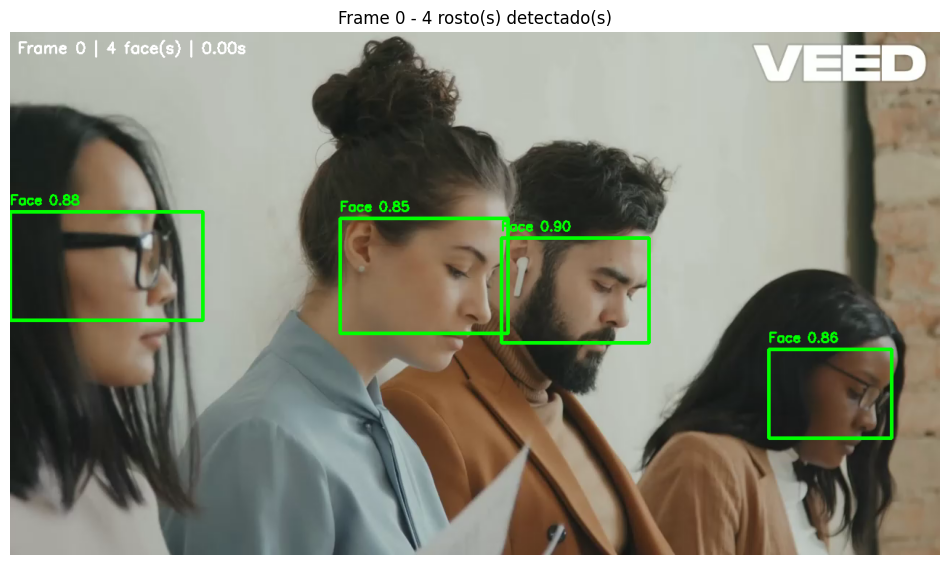

In [4]:
import matplotlib.pyplot as plt

# Pegar um frame novamente
processor = VideoProcessor("meu_video.mp4")
frame_num, timestamp, frame = next(processor.get_frames())

# Detectar rostos
faces = detector.detect(frame)

# Criar cópia do frame para desenhar (não modificar o original)
frame_with_boxes = frame.copy()

# Desenhar bounding boxes manualmente
# (Mais adiante criaremos funções reutilizáveis para isso)
for face in faces:
    bbox = face.bounding_box
    confidence = face.confidence
    
    # Desenhar retângulo verde
    cv2.rectangle(
        frame_with_boxes,
        (bbox.x, bbox.y),
        (bbox.x + bbox.width, bbox.y + bbox.height),
        (0, 255, 0),  # Verde em BGR
        3  # Espessura da linha
    )
    
    # Adicionar texto com confiança
    cv2.putText(
        frame_with_boxes,
        f"Face {confidence:.2f}",
        (bbox.x, bbox.y - 10),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.6,
        (0, 255, 0),
        2
    )

# Adicionar informações do frame no canto superior
cv2.putText(
    frame_with_boxes,
    f"Frame {frame_num} | {len(faces)} face(s) | {timestamp:.2f}s",
    (10, 30),
    cv2.FONT_HERSHEY_SIMPLEX,
    0.7,
    (255, 255, 255),
    2
)

# Converter BGR para RGB para matplotlib (OpenCV usa BGR, matplotlib usa RGB)
frame_rgb = cv2.cvtColor(frame_with_boxes, cv2.COLOR_BGR2RGB)

# Mostrar imagem
plt.figure(figsize=(12, 8))
plt.imshow(frame_rgb)
plt.title(f"Frame {frame_num} - {len(faces)} rosto(s) detectado(s)")
plt.axis('off')
plt.show()

processor.release()

Nota: Na próxima célula, vamos criar funções reutilizáveis para tornar este código mais limpo e fácil de manter.

### Passo 5: Criar Funções Reutilizáveis de Visualização

Agora que entendemos como desenhar as detecções manualmente, vamos criar
funções reutilizáveis para tornar o código mais limpo e fácil de manter.

**Por que criar funções reutilizáveis?**
- ✅ Evita repetição de código
- ✅ Facilita manutenção (mudanças em um lugar só)
- ✅ Torna o código mais legível
- ✅ Permite reutilização em diferentes partes do notebook


In [5]:
"""
Criar funções reutilizáveis para visualização de detecções.

Essas funções serão usadas em todo o notebook para manter o código
organizado e reutilizável.
"""
import cv2
import numpy as np
from typing import List, Tuple, Optional

# Cores padrão (formato BGR do OpenCV)
COLOR_GREEN = (0, 255, 0)
COLOR_RED = (0, 0, 255)
COLOR_WHITE = (255, 255, 255)


def draw_bounding_box(
    frame: np.ndarray,
    bbox: BoundingBox,
    color: Tuple[int, int, int] = COLOR_GREEN,
    thickness: int = 2,
    label: Optional[str] = None
) -> np.ndarray:
    """
    Desenha um bounding box em um frame.
    
    Esta função é pura (não modifica o frame original) e retorna uma cópia
    com o bounding box desenhado.
    
    Args:
        frame: Frame do vídeo (numpy array, formato BGR)
        bbox: BoundingBox a ser desenhado
        color: Cor do retângulo em formato BGR (padrão: verde)
        thickness: Espessura da linha (padrão: 2)
        label: Texto opcional para exibir acima do bounding box
    
    Returns:
        Frame com o bounding box desenhado (cópia, não modifica o original)
    """
    frame_copy = frame.copy()
    
    # Desenhar retângulo
    cv2.rectangle(
        frame_copy,
        (bbox.x, bbox.y),
        (bbox.x + bbox.width, bbox.y + bbox.height),
        color,
        thickness
    )
    
    # Adicionar label se fornecido
    if label:
        # Calcular posição do texto (acima do bounding box)
        text_y = max(bbox.y - 10, 20)  # Garantir que não fique fora da tela
        
        cv2.putText(
            frame_copy,
            label,
            (bbox.x, text_y),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.6,
            color,
            2
        )
    
    return frame_copy


def draw_face_detections(
    frame: np.ndarray,
    faces: List[FaceDetection],
    show_confidence: bool = True
) -> np.ndarray:
    """
    Desenha múltiplos bounding boxes de rostos detectados em um frame.
    
    Esta função é uma abstração de alto nível que usa draw_bounding_box
    internamente para desenhar todos os rostos detectados.
    
    Args:
        frame: Frame do vídeo (numpy array, formato BGR)
        faces: Lista de FaceDetection com os rostos detectados
        show_confidence: Se True, exibe a confiança acima de cada rosto
    
    Returns:
        Frame com todos os bounding boxes desenhados
    """
    frame_copy = frame.copy()
    
    for i, face in enumerate(faces):
        bbox = face.bounding_box
        
        # Criar label com confiança se solicitado
        label = None
        if show_confidence:
            label = f"Face {face.confidence:.2f}"
        
        # Desenhar bounding box usando função reutilizável
        frame_copy = draw_bounding_box(
            frame_copy,
            bbox,
            color=COLOR_GREEN,
            thickness=3,
            label=label
        )
    
    return frame_copy


def add_frame_info(
    frame: np.ndarray,
    frame_number: int,
    total_frames: Optional[int] = None,
    faces_count: Optional[int] = None,
    timestamp: Optional[float] = None
) -> np.ndarray:
    """
    Adiciona informações do frame no canto superior esquerdo.
    
    Esta função é útil para debug e visualização, mostrando informações
    como número do frame, timestamp, quantidade de rostos detectados, etc.
    
    Args:
        frame: Frame do vídeo (numpy array, formato BGR)
        frame_number: Número do frame atual
        total_frames: Total de frames no vídeo (opcional)
        faces_count: Quantidade de rostos detectados (opcional)
        timestamp: Timestamp em segundos (opcional)
    
    Returns:
        Frame com informações adicionadas
    """
    frame_copy = frame.copy()
    
    # Construir texto de informação
    info_parts = [f"Frame {frame_number}"]
    
    if total_frames is not None:
        info_parts.append(f"/{total_frames}")
    
    if timestamp is not None:
        info_parts.append(f" | {timestamp:.2f}s")
    
    if faces_count is not None:
        info_parts.append(f" | {faces_count} face(s)")
    
    info_text = "".join(info_parts)
    
    # Desenhar texto
    cv2.putText(
        frame_copy,
        info_text,
        (10, 30),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.7,
        COLOR_WHITE,
        2
    )
    
    return frame_copy


def frame_to_rgb(frame: np.ndarray) -> np.ndarray:
    """
    Converte frame de BGR (OpenCV) para RGB (matplotlib).
    
    Esta função é útil quando você quer exibir frames do OpenCV
    usando matplotlib, que espera formato RGB.
    
    Args:
        frame: Frame em formato BGR (OpenCV)
    
    Returns:
        Frame em formato RGB (matplotlib)
    """
    return cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)


print("✅ Funções de visualização criadas!")
print("\n📋 Funções disponíveis:")
print("   - draw_bounding_box(): Desenha um bounding box")
print("   - draw_face_detections(): Desenha múltiplos rostos")
print("   - add_frame_info(): Adiciona informações do frame")
print("   - frame_to_rgb(): Converte BGR para RGB")


✅ Funções de visualização criadas!

📋 Funções disponíveis:
   - draw_bounding_box(): Desenha um bounding box
   - draw_face_detections(): Desenha múltiplos rostos
   - add_frame_info(): Adiciona informações do frame
   - frame_to_rgb(): Converte BGR para RGB


### Passo 6: Processar Vídeo Completo com Visualização em Tempo Real

Agora vamos processar o vídeo completo usando as funções reutilizáveis que criamos.
Esta solução permite visualizar em tempo real enquanto processa, sem precisar parar o que está fazendo.


In [6]:
"""
Processa vídeo completo com visualização em tempo real.

Esta função integra VideoProcessor e FaceDetector para processar
um vídeo completo, mostrando preview em tempo real e opcionalmente
salvando o resultado.
"""
import cv2
from pathlib import Path
from typing import Optional

def process_video_with_detections(
    video_processor,
    face_detector,
    output_path: Optional[str] = None,
    show_preview: bool = True,
    preview_window_name: str = "Face Detection - Preview"
) -> dict:
    """
    Processa um vídeo completo detectando rostos em cada frame.
    
    Esta função integra VideoProcessor e FaceDetector para processar
    um vídeo completo, opcionalmente salvando o resultado e/ou mostrando
    preview em tempo real.
    
    Args:
        video_processor: Instância de VideoProcessor já inicializada
        face_detector: Instância de FaceDetector já inicializada
        output_path: Caminho para salvar vídeo processado (opcional)
        show_preview: Se True, mostra preview em tempo real
        preview_window_name: Nome da janela de preview
    
    Returns:
        Dicionário com estatísticas do processamento
    """
    # Obter informações do vídeo
    video_info = video_processor.get_video_info()
    fps = video_info['fps']
    width = video_info['width']
    height = video_info['height']
    total_frames = video_info['frame_count']
    
    print(f"📹 Vídeo: {width}x{height} @ {fps:.2f}fps, {total_frames} frames")
    print(f"⏱️  Duração: {video_info['duration']:.2f} segundos")
    
    # Criar VideoWriter se necessário
    video_writer = None
    if output_path:
        output_path_obj = Path(output_path)
        output_path_obj.parent.mkdir(parents=True, exist_ok=True)
        
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        video_writer = cv2.VideoWriter(
            str(output_path),
            fourcc,
            fps,
            (width, height)
        )
        print(f"💾 Vídeo será salvo em: {output_path}")
    
    # Estatísticas
    frame_count = 0
    total_faces = 0
    
    print("\n🎬 Processando vídeo frame por frame...")
    print("   Pressione 'q' na janela de preview para parar\n")
    
    # Processar cada frame
    for frame_num, timestamp, frame in video_processor.get_frames():
        # Detectar rostos usando nosso FaceDetector
        faces = face_detector.detect(frame)
        
        # Desenhar detecções usando função reutilizável
        frame_with_detections = draw_face_detections(frame, faces)
        
        # Adicionar informações do frame usando função reutilizável
        frame_with_detections = add_frame_info(
            frame_with_detections,
            frame_num,
            total_frames=total_frames,
            faces_count=len(faces),
            timestamp=timestamp
        )
        
        # Salvar frame se necessário
        if video_writer:
            video_writer.write(frame_with_detections)
        
        # Mostrar preview em tempo real
        if show_preview:
            cv2.imshow(preview_window_name, frame_with_detections)
            # Pausar para permitir visualização (ajustar conforme FPS)
            # waitKey(1) permite que a janela seja atualizada
            key = cv2.waitKey(1) & 0xFF
            if key == ord('q'):  # Pressionar 'q' para sair
                print("\n⚠️  Processamento interrompido pelo usuário")
                break
        
        # Atualizar estatísticas
        frame_count += 1
        total_faces += len(faces)
        
        # Mostrar progresso a cada 30 frames
        if frame_count % 30 == 0:
            progress = (frame_count / total_frames) * 100
            print(f"   Progresso: {progress:.1f}% "
                  f"({frame_count}/{total_frames} frames) | "
                  f"Média: {total_faces/frame_count:.2f} faces/frame")
    
    # Limpar recursos
    if video_writer:
        video_writer.release()
        print(f"\n💾 Vídeo salvo em: {output_path}")
    
    if show_preview:
        cv2.destroyAllWindows()
    
    # Retornar estatísticas
    stats = {
        'total_frames': frame_count,
        'total_faces': total_faces,
        'avg_faces_per_frame': total_faces / frame_count if frame_count > 0 else 0,
        'output_path': output_path if output_path else None
    }
    
    print(f"\n✅ Processamento concluído!")
    print(f"   Total de frames processados: {stats['total_frames']}")
    print(f"   Total de rostos detectados: {stats['total_faces']}")
    print(f"   Média de rostos por frame: {stats['avg_faces_per_frame']:.2f}")
    
    return stats


# Agora vamos usar a função para processar nosso vídeo
processor = VideoProcessor("meu_video.mp4")
detector = FaceDetector(model_path="yolo11n-pose.pt", confidence_threshold=0.5)

# Processar vídeo com preview em tempo real
# Você pode salvar o vídeo também passando output_path="output_video/video_com_deteccoes.mp4"
stats = process_video_with_detections(
    processor,
    detector,
    output_path="output_video/video_com_deteccoes.mp4",  # Opcional: None para não salvar
    show_preview=True  # True para ver em tempo real
)

# Liberar recursos
processor.release()


✅ FaceDetector inicializado (Pose model, threshold: 0.5)
📹 Vídeo: 1280x720 @ 30.00fps, 3326 frames
⏱️  Duração: 110.87 segundos
💾 Vídeo será salvo em: output_video/video_com_deteccoes.mp4

🎬 Processando vídeo frame por frame...
   Pressione 'q' na janela de preview para parar



qt.qpa.plugin: Could not find the Qt platform plugin "wayland" in "/home/lucas-biason/Projetos/Estudos/Tech Challengers FIAP/fiap-tech-challenger-fase04/.venv/lib/python3.13/site-packages/cv2/qt/plugins"


   Progresso: 0.9% (30/3326 frames) | Média: 4.00 faces/frame
   Progresso: 1.8% (60/3326 frames) | Média: 4.10 faces/frame
   Progresso: 2.7% (90/3326 frames) | Média: 4.07 faces/frame
   Progresso: 3.6% (120/3326 frames) | Média: 4.04 faces/frame
   Progresso: 4.5% (150/3326 frames) | Média: 3.99 faces/frame
   Progresso: 5.4% (180/3326 frames) | Média: 3.81 faces/frame
   Progresso: 6.3% (210/3326 frames) | Média: 3.40 faces/frame
   Progresso: 7.2% (240/3326 frames) | Média: 3.10 faces/frame
   Progresso: 8.1% (270/3326 frames) | Média: 2.87 faces/frame
   Progresso: 9.0% (300/3326 frames) | Média: 2.68 faces/frame
   Progresso: 9.9% (330/3326 frames) | Média: 2.53 faces/frame
   Progresso: 10.8% (360/3326 frames) | Média: 2.40 faces/frame
   Progresso: 11.7% (390/3326 frames) | Média: 2.22 faces/frame
   Progresso: 12.6% (420/3326 frames) | Média: 2.06 faces/frame
   Progresso: 13.5% (450/3326 frames) | Média: 1.92 faces/frame
   Progresso: 14.4% (480/3326 frames) | Média: 1.80 fa